## This is a Julia version of the code for Einstein_Scalar_field

See paper: *On free evolution of self gravitating, spherically symmetric waves.*

In [5]:
using OrdinaryDiffEq
using SummationByPartsOperators
#using DifferentialEquations
using Plots
#using LinearAlgebra
#using BandedMatrices


In [146]:
N = 800 #grid steps
x_i = 1.0; x_f = 20.0 #region 
dx = (x_f-x_i)/(N-1)
U = 5 #number of fields (f,g,h,χ_+,χ_-)
dT = 0.1*dx
u0 = zeros(N*U)
du = zeros(N*U)

D = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=4, xmin=x_i, xmax=x_f, N=N)

x = SummationByPartsOperators.grid(D)

1.0:0.023779724655819776:20.0

In [147]:
function F!(du,u,p,t)
    # second order version
    D, x, dx, A, ω, τ = p
    
    f = @view u[1:N]
    g = @view u[N+1:2N]
    h = @view u[2N+1:3N]
    χ₊ = @view u[3N+1:4N]
    χ₋ = @view u[4N+1:5N]

    df = @view du[1:N]
    dg = @view du[N+1:2N]
    dh = @view du[2N+1:3N]
    dχ₊ = @view du[3N+1:4N]
    dχ₋ = @view du[4N+1:5N]

    #= this is only the original system, not the one we actually evolve!
    @. df = D*f 
    @. dg = D*g
    @. dh = D*h - df/2/f/x + (g-2)/2/f/h/x * dg - (g-f)*h/f/x -(g-2+f)/2/f/x^2 + 2*((χ₊ + χ₋)/f/x)^2 
    @. dg = -g/f * df + (f-2)/f * dg + 2g*h -g*(g-2+f)/f/x  
    @. df = df + (g-2+f)/x 
    @. dχ₊ = D*χ₊ - (f-2)* χ₋ /f/x
    @. dχ₋ = (f-2)/f * D*χ₋ 2χ₋ *(2x*(f-2)*h + 2 - g -f)/f^2/x + 8χ₋*(χ₊)^2/f^3/x - χ₊/x
    =#
    @. df = 2*(f-2)*h + 4* (χ₊)^2 /f/x
    @. dg = 2*g*h - 2g* (χ₊)^2 /f/x + 2g*(f-2)* (χ₋)^2/ f^2/x 
    dh = D*h
    @. dh = dh + (- (g-2)* (χ₊)^2 + 4χ₊*χ₋ + g* (χ₋)^2 ) /f^2/x^2
    dh[end] = dh[end] - 1.0/right_boundary_weight(D) *h[end] #penalty BC
    
    dχ₊ = D*χ₊
    @. dχ₊ = dχ₊ - (f-2)* χ₋ /f/x
    dχ₋ = D*χ₋
    @. dχ₋ = (f-2)/f * dχ₋ + 2χ₋ *(2x*(f-2)*h + 2 - g -f)/f^2/x + 8χ₋*(χ₊)^2/f^3/x - χ₊/x
    dχ₊[end] = dχ₊[end] - 1.0/right_boundary_weight(D) * (χ₊[end] - A*sin(ω*t)*exp(-t/τ)) #penalty BC
    if f[1]<2.0
        dχ₋[1] = dχ₋[1] + (f[1]-2)/f[1]/right_boundary_weight(D) *(χ₋[1] - χ₊[1]) #penalty BC
    end
    
    @. du = [df; dg; dh; dχ₊; dχ₋]
end

F! (generic function with 1 method)

In [148]:
# put some boundary data
A = 1.0; ω = 2π; τ = 10.0
p = (D, x, dx, A, ω, τ)

f = @view u0[1:N]
g = @view u0[N+1:2N]
h = @view u0[2N+1:3N]
χ₊ = @view u0[3N+1:4N]
χ₋ = @view u0[4N+1:5N]

f .= 1.0;
g .= 1.0;
#rest set to zero

#D*f

p

(SBP first-derivative operator of order 4 on a grid in [1.0, 20.0] using 800 nodes 
and coefficients of Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., 1.0:0.023779724655819776:20.0, 0.023779724655819776, 1.0, 6.283185307179586, 10.0)

In [93]:
right_boundary_weight(D)

0.016017587939698492

In [152]:
T=40
prob = ODEProblem(F!,u0,(0.0,T),p);
sol = solve(prob,RK4(),dt=dT,adaptive=false);

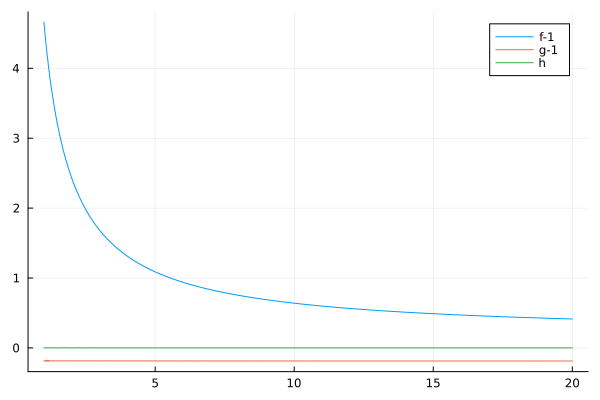

In [156]:
t = T
plot(x,sol(t)[1:N].-1.0, label = "f-1")
plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
plot!(x,sol(t)[2N+1:3N], label = "h")

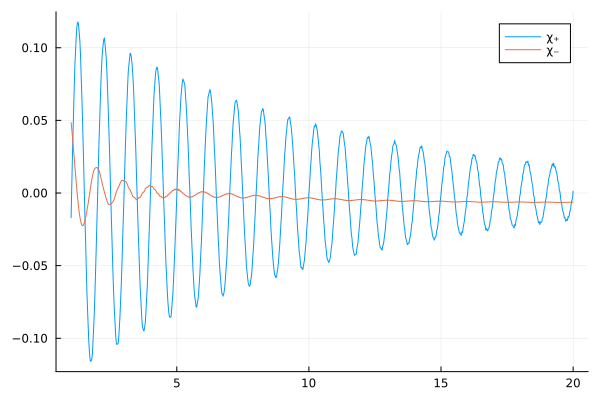

In [154]:
t = 40
plot(x,sol(t)[3N+1:4N], label = "χ₊")
plot!(x,sol(t)[4N+1:5N], label = "χ₋")

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/fgh_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/fgh_fps5.gif")
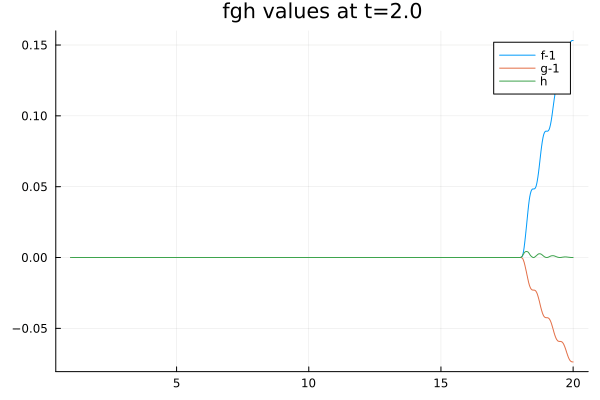

In [160]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="fgh values at t=$t")
    plot!(x,sol(t)[1:N].-1.0, label = "f-1")
    plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
    plot!(x,sol(t)[2N+1:3N], label = "h")
end

gif(anim, "fgh_fps5.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/Users/reula/Julia/Vlasov/E-V/scalar_fps5.gif")
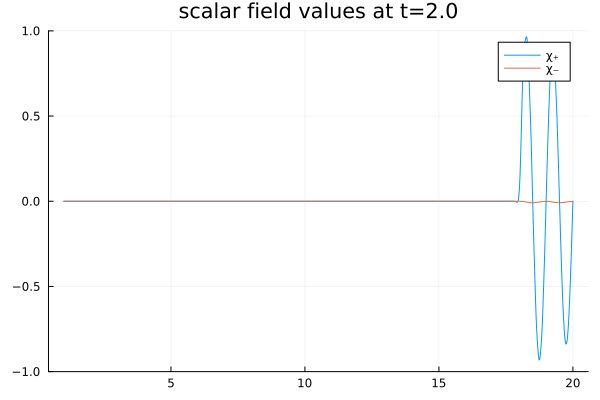

In [162]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="scalar field values at t=$t", ylim=(-1,1))
    plot!(x,sol(t)[3N+1:4N], label = "χ₊")
    plot!(x,sol(t)[4N+1:5N], label = "χ₋")
end

gif(anim, "scalar_fps5.gif", fps = 5)